In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pairwise_distances(X):
    return np.sum((X[None, :] - X[:, None])**2, 2)

In [3]:
def p_conditional(dists, sigmas):
    e = np.exp(-dists / (2 * np.square(sigmas.reshape((-1,1)))))
    np.fill_diagonal(e, 0.)
    e += 1e-8
    return e / e.sum(axis=1).reshape([-1,1])

In [31]:
def perp(condi_matr):
    # print(condi_matr)
    ent = -np.sum(condi_matr * np.log2(condi_matr), 1)
    return 2 ** ent

In [32]:
def search(func, goal, tol=1e-10, max_iters=50, lowb=1e-20, uppb=10000):
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2.
        val = func(guess)

        # print(val, guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess

        if np.abs(val - goal) <= tol:
            return guess
    return guess

In [33]:
def find_sigmas(dists, perplexity):
    found_sigmas = np.zeros(dists.shape[0])
    for i in range(dists.shape[0]):
        func = lambda sig: perp(p_conditional(dists[i:i+1, :], np.array([sig])))
        found_sigmas[i] = search(func, perplexity)
    return found_sigmas

In [23]:
mu1 = np.ones(10)
mu2 = 10 * np.ones(10)
cov = 0.01 * np.eye(10)
n = 10

np.random.seed(42)
cluster1 = np.random.multivariate_normal(mu1, cov, size=n)
cluster2 = np.random.multivariate_normal(mu2, cov, size=n)
X = np.concatenate([cluster1, cluster2], axis=0)

low_dim = 2
T = 50

In [34]:
learning_rate = 1e-3
alpha = 0.5
target_perplexity = 5
find_sigmas(pairwise_distances(X), target_perplexity)

array([0.16030963, 0.18122192, 0.16220361, 0.21558762, 0.16298187,
       0.19673904, 0.18634917, 0.22360027, 0.17406192, 0.15643479,
       0.1677423 , 0.20768401, 0.20558151, 0.17648539, 0.18876867,
       0.18627286, 0.18789355, 0.2042914 , 0.17501983, 0.16198767])

In [14]:
def q_joint(y):
    dists = pairwise_distances(y)
    nom = 1 / (1 + dists)
    np.fill_diagonal(nom, 0.)
    return nom / np.sum(np.sum(nom))

In [15]:
def gradient(P, Q, y):
    (n, no_dims) = y.shape
    pq_diff = P - Q
    y_diff = np.expand_dims(y,1) - np.expand_dims(y,0)

    dists = pairwise_distances(y)
    aux = 1 / (1 + dists)
    return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux,2)).sum(1)

In [16]:
def m(t):
    # return 0.5 if t < 250 else 0.8
    return 0.5

In [17]:
def p_joint(X, perp):
    N = X.shape[0]
    dists = pairwise_distances(X)
    sigmas = find_sigmas(dists, perp)
    p_cond = p_conditional(dists, sigmas)
    return (p_cond + p_cond.T) / (2. * N)

In [19]:
def plot_points(Y):
    n = Y.shape[0]//2
    plt.scatter(Y[:n, 0], Y[:n, 1], color='red')
    plt.scatter(Y[n:, 0], Y[n:, 1], color='blue')
    plt.show()

In [49]:
def tsne(X, ydim=2, T=1000, l=500, perp=30):
    N = X.shape[0]
    P = p_joint(X, perp)
    Y = []
    # np.random.seed(42)
    # y = np.random.normal(loc=0.0, scale=1e-4, size=(N,ydim))
    y = [[ 7.38466580e-05,  1.71368281e-05],
        [-1.15648282e-05, -3.01103696e-05],
        [-1.47852199e-04, -7.19844208e-05],
        [-4.60638771e-05,  1.05712223e-04],
        [ 3.43618290e-05, -1.76304016e-04],
        [ 3.24083969e-05, -3.85082280e-05],
        [-6.76922000e-05,  6.11676289e-05],
        [ 1.03099952e-04,  9.31280119e-05],
        [-8.39217523e-05, -3.09212376e-05],
        [ 3.31263431e-05,  9.75545127e-05],
        [-4.79174238e-05, -1.85658977e-05],
        [-1.10633497e-04, -1.19620662e-04],
        [ 8.12525822e-05,  1.35624003e-04],
        [-7.20101216e-06,  1.00353290e-04],
        [ 3.61636025e-05, -6.45119755e-05],
        [ 3.61395606e-05,  1.53803657e-04],
        [-3.58260391e-06,  1.56464366e-04],
        [-2.61974510e-04,  8.21902504e-05],
        [ 8.70470682e-06, -2.99007350e-05],
        [ 9.17607765e-06, -1.98756891e-04]]
    y = np.array(y)
    Y.append(y); Y.append(y)
    plot_points(y)
    for t in range(T):
        Q = q_joint(Y[-1])
        grad = gradient(P, Q, Y[-1])
        print(Q)
        print(grad)
        y = Y[-1] - l*grad + m(t)*(Y[-1] - Y[-2])
        Y.append(y)
        if t % 10 == 0:
            Q = np.maximum(Q, 1e-12)
    plot_points(y)
    return y

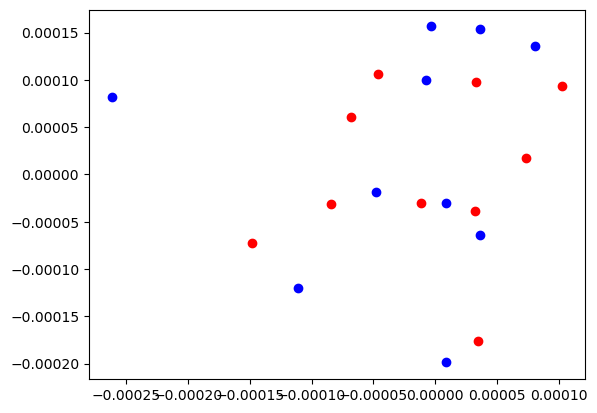

[[0.         0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158]
 [0.00263158 0.         0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158]
 [0.00263158 0.00263158 0.         0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158]
 [0.00263158 0.00263158 0.00263158 0.         0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158 0.00263158 0.00263158 0.00263158 0.00263158
  0.00263158 0.00263158]
 [0.00263158 0.00263158 0.00263158 0.00263158 0.         0.00263158
  0.00263158 0.0

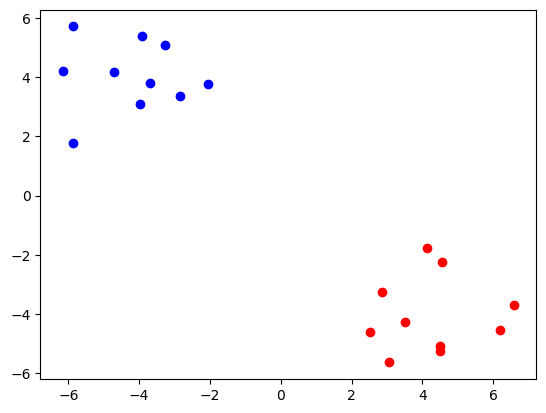

In [52]:
learning_rate = 50
alpha = 0.5
target_perplexity = 5
Y = tsne(X, ydim=2, T=20, l=learning_rate, perp=target_perplexity)